## Fraud

### Goal

E-commerce websites often transact huge amounts of money. And whenever a huge amount of money is moved, there is a high risk of users performing fraudulent activities, e.g. using stolen credit cards or doing money laundry. 

Machine Learning really excels at identifying fraudulent activities. Any website where you put your credit card information has a risk team in charge of avoiding frauds via machine learning. 

The goal of this challenge is to build a machine learning model that predicts the probability that the first transaction of a new user is fraudulent.

#### Challenge Description

Company XYZ is an e-commerce site that sells hand-made clothes.

You have to build a model that predicts whether a user has a high probability of using the site to perform some illegal activity or not. This is a super common task for data scientists.

You only have information about the user first transaction on the site and based on that you have to make your classification (“fraud/no fraud”).

These are the tasks you are asked to do:
1. For each user, determine their country based on the IP address
2. Build a model to predict whether an activity is fraudulent or not. Explain how different assumptions about the cost of false positives vs false negatives would impact the model
3. Your boss is a bit worried about using a model she doesn’t understand for something as important as fraud detection. How would you explain her how the model is making the predictions? Not from a mathematical perspective (she couldn’t care less about that), but from a user perspective. What kinds of users are more likely to be classified as at risk? What are their characteristics?
4. Let’s say you now have this model which can be used live to predict in real time if an activity is fraudulent or not. From a product perspective, how would you use it? That is, what kind of different user experiences would you build based on the model output? 


##### Import Library and Read Data 

In [35]:
import pandas as pd
import numpy as np
pandas.set_option('display.max_columns', 20)
pandas.set_option('display.width', 350)
  
import  warnings
warnings.simplefilter('ignore')

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import auc, roc_curve, classification_report,confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
np.random.seed(4684)
    
from datetime import datetime

# import h2o
# from h2o.frame import H2OFrame
# from h2o.estimators.random_forest import H2ORandomForestEstimator

%matplotlib inline 

In [3]:
#read from google drive
data=pandas.read_csv("https://drive.google.com/uc?export=download&id=18RLruiMU8rM-IQPLdwL6wNEc8Kks2JZQ")

#Second dataset can be used to get user country based on their Ip address. 
#For each country, it gives a range. If the numeric ip address falls within that range
#then the ip address belongs to the corresponding country
ip_addresses=pandas.read_csv("https://drive.google.com/uc?export=download&id=1wbKys6YI-IvE-b-C0_4xR4zz2YnpOL1d")


In [4]:
# Data shape, column name/type and etc. 
print(data.info())
# Change ip_address to integer 
data['ip_address'] = data['ip_address'].astype('int64')
#make them dates
data["signup_time"]   = pandas.to_datetime(data["signup_time"])
data["purchase_time"] = pandas.to_datetime(data["purchase_time"])
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151112 entries, 0 to 151111
Data columns (total 11 columns):
user_id           151112 non-null int64
signup_time       151112 non-null object
purchase_time     151112 non-null object
purchase_value    151112 non-null int64
device_id         151112 non-null object
source            151112 non-null object
browser           151112 non-null object
sex               151112 non-null object
age               151112 non-null int64
ip_address        151112 non-null float64
class             151112 non-null int64
dtypes: float64(1), int64(4), object(6)
memory usage: 12.7+ MB
None


,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,732758368,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,350311387,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2621473820,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3840542443,0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,415583117,0


In [29]:
print(ip_addresses.info())
# Change ip_address to integer 
ip_addresses['lower_bound_ip_address'] = ip_addresses['lower_bound_ip_address'].astype('int64')
ip_addresses.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 138846 entries, 0 to 138845
Data columns (total 3 columns):
lower_bound_ip_address    138846 non-null int64
upper_bound_ip_address    138846 non-null int64
country                   138846 non-null object
dtypes: int64(2), object(1)
memory usage: 3.2+ MB
None


,lower_bound_ip_address,upper_bound_ip_address,country
0,16777216,16777471,Australia
1,16777472,16777727,China
2,16777728,16778239,China
3,16778240,16779263,Australia
4,16779264,16781311,China


##### Q1: Add countries to Fraud dataset 

In [5]:
# Merge two datasets based on ip_address 
countries = []
for i in range(len(data)):
    ip_address = data.loc[i, 'ip_address']
    tmp = ip_addresses[(ip_addresses['lower_bound_ip_address'] <= ip_address) &
                       (ip_addresses['upper_bound_ip_address'] >= ip_address)]
    if len(tmp) == 1:
        countries.append(tmp['country'].values[0])
    else:
        countries.append('NA')
data['country'] = countries

In [6]:
data.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,732758368,0,Japan
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,350311387,0,United States
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2621473820,1,United States
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3840542443,0,NA
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,415583117,0,United States


In [7]:
# Check Missing country 
sum(data['country']=='NA')

21966

In [8]:
data['country'].value_counts(sort=True)[0:10]

United States        58049
NA                   21966
China                12038
Japan                 7306
United Kingdom        4490
Korea Republic of     4162
Germany               3646
France                3161
Canada                2975
Brazil                2961
Name: country, dtype: int64

##### Feature Engineering

Before jumping into building a model, think about whether you can create new powerful variables. 
This is called feature engineering and it is the most important step in machine learning. 
However, feature engineering is quite time consuming. 
In a take-home you should just give an idea of how you would do it and emphasize that with more time you would go deeper into it.

A few obvious variables that can be created here could be:
1. Time difference between sign-up time and purchase time
2. If the device id is unique or certain users are sharing the same device (many different user ids using the same device could be an indicator of fake accounts)
3. Same for the ip address. Many different users having the same ip address could be an indicator of fake accounts
4. Usual week of the year and day of the week from time variables

In [9]:
# 1. time difference 
data['time_diff']= data['purchase_time']-data['signup_time']
# To seconds
data['time_diff']= data['time_diff'].dt.total_seconds()
data['time_diff'].describe()

count    1.511120e+05
mean     4.932029e+06
std      3.126263e+06
min      1.000000e+00
25%      2.186754e+06
50%      4.926346e+06
75%      7.644525e+06
max      1.036797e+07
Name: time_diff, dtype: float64

In [10]:
data.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country,time_diff
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,732758368,0,Japan,4506682.0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,350311387,0,United States,17944.0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2621473820,1,United States,1.0
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3840542443,0,NA,492085.0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,415583117,0,United States,4361461.0


In [11]:
# 2. If the device id is unique or certain users are sharing the same device
device_num = data[['user_id', 'device_id']].groupby('device_id').count().reset_index()
device_num = device_num.rename(columns={'user_id': 'device_num'})
device_num.head()

,device_id,device_num
0,AAALBGNHHVMKG,1
1,AAAWIHVCQELTP,1
2,AAAXJHWCLISKY,1
3,AAAXXOZJRZRAO,11
4,AABFGRPBQHWFQ,1


In [12]:
data = data.merge(device_num,on='device_id',how='left')
# data = data.rename(columns={'device_num_x': 'device_num'})
# drop last column
# data = data.iloc[:, :-1] 
data.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country,time_diff,device_num
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,732758368,0,Japan,4506682.0,1
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,350311387,0,United States,17944.0,1
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2621473820,1,United States,1.0,12
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3840542443,0,NA,492085.0,1
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,415583117,0,United States,4361461.0,1


In [13]:
# 3. Same for the ip address.
ip_num = data[['user_id','ip_address']].groupby(['ip_address']).count().reset_index()
ip_num.rename(columns={'user_id':'ip_num'},inplace=True)
ip_num.head()

,ip_address,ip_num
0,52093,1
1,93447,1
2,105818,1
3,117566,1
4,131423,1


In [14]:
data = data.merge(ip_num, how='left', on='ip_address')
data.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country,time_diff,device_num,ip_num
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,732758368,0,Japan,4506682.0,1,1
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,350311387,0,United States,17944.0,1,1
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2621473820,1,United States,1.0,12,12
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3840542443,0,NA,492085.0,1,1
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,415583117,0,United States,4361461.0,1,1


In [15]:
# Check 
ip_num[ip_num['ip_address']==2621473820]

,ip_address,ip_num
87282,2621473820,12


In [16]:
# 4. Usual week of the year and day of the week from time variables
# Signup day and week
data['signup_day'] = data['signup_time'].apply(lambda x: x.dayofweek)
data['signup_week'] = data['signup_time'].apply(lambda x: x.week)

# Purchase day and week
data['purchase_day'] = data['purchase_time'].apply(lambda x: x.dayofweek)
data['purchase_week'] = data['purchase_time'].apply(lambda x: x.week)

data.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country,time_diff,device_num,ip_num,signup_day,signup_week,purchase_day,purchase_week
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,732758368,0,Japan,4506682.0,1,1,1,9,5,16
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,350311387,0,United States,17944.0,1,1,6,23,0,24
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2621473820,1,United States,1.0,12,12,3,1,3,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3840542443,0,NA,492085.0,1,1,1,18,0,19
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,415583117,0,United States,4361461.0,1,1,1,30,2,37


##### EDA

No Frauds 90.64 % of the dataset
Frauds 9.36 % of the dataset


Text(0.5, 1.0, 'Class Distributions 0: No Fraud || 1: Fraud')

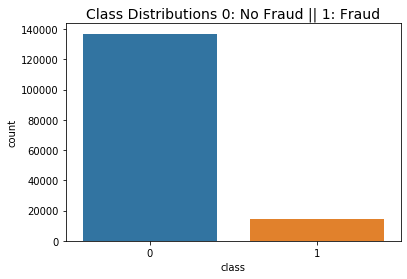

In [17]:
# The classes are heavily skewed
print('No Frauds', round(data['class'].value_counts()[0]/len(data) * 100,2), '% of the dataset')
print('Frauds', round(data['class'].value_counts()[1]/len(data) * 100,2), '% of the dataset')
# Plot
sns.countplot('class', data=data)
plt.title('Class Distributions 0: No Fraud || 1: Fraud', fontsize=14)

In [18]:
def pctFraud(var,value):
    pct = round((sum((data['class']==1) & (data[var]==value))/sum(data[var]==value))*100,2)
    print(value,':',pct,'% are fraud')

SEO       60615
Ads       59881
Direct    30616
Name: source, dtype: int64


SEO : 8.93 % are fraud
Ads : 9.21 % are fraud
Direct : 10.54 % are fraud


Text(0.5, 1.0, 'Count Plot of Source')

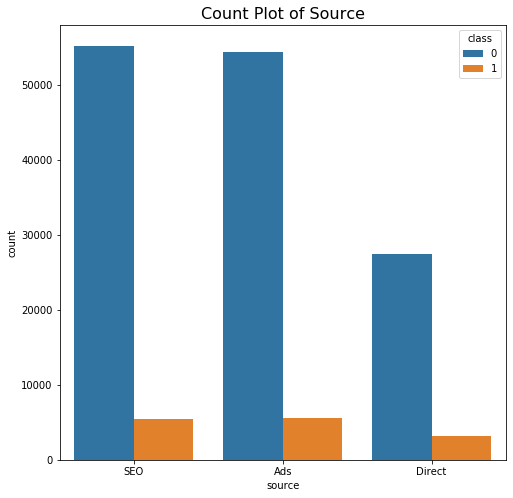

In [19]:
# Source 
print(data['source'].value_counts())
print('\n')
pctFraud('source','SEO')
pctFraud('source','Ads')
pctFraud('source','Direct')
# Visualization
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
sns.countplot(x='source', hue='class', data=data, ax=ax)
ax.set_title('Count Plot of Source', fontsize=16)

M    88293
F    62819
Name: sex, dtype: int64


F : 9.1 % are fraud
M : 9.55 % are fraud


Text(0.5, 1.0, 'Count Plot of Sex')

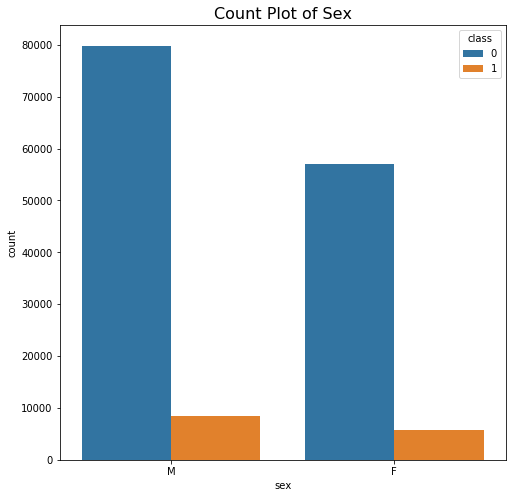

In [20]:
# sex
print(data['sex'].value_counts())
print('\n')
pctFraud('sex','F')
pctFraud('sex','M')
# Visualization
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
sns.countplot(x='sex', hue='class', data=data, ax=ax)
ax.set_title('Count Plot of Sex', fontsize=16)

Chrome     61432
IE         36727
Safari     24667
FireFox    24610
Opera       3676
Name: browser, dtype: int64


Chrome : 9.88 % are fraud
IE : 8.68 % are fraud
Safari : 9.02 % are fraud
FireFox : 9.52 % are fraud
Opera : 8.92 % are fraud


Text(0.5, 1.0, 'Count Plot of browser')

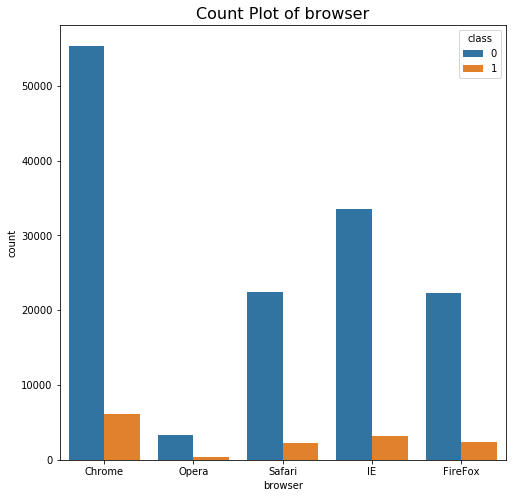

In [21]:
# browser
print(data['browser'].value_counts())
print('\n')
pctFraud('browser','Chrome')
pctFraud('browser','IE')
pctFraud('browser','Safari')
pctFraud('browser','FireFox')
pctFraud('browser','Opera')

# Visualization
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
sns.countplot(x='browser', hue='class', data=data, ax=ax)
ax.set_title('Count Plot of browser', fontsize=16)

United States        58049
NA                   21966
China                12038
Japan                 7306
United Kingdom        4490
Korea Republic of     4162
Germany               3646
France                3161
Canada                2975
Brazil                2961
Name: country, dtype: int64


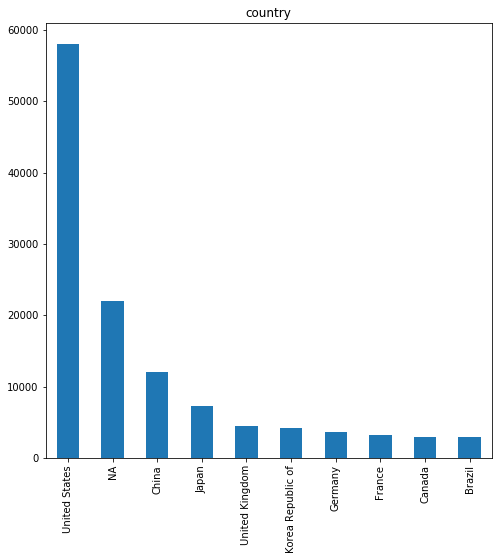

In [22]:
# Country
print(data['country'].value_counts(sort=True)[0:10])
f, ax = plt.subplots(1, 1, figsize=(8, 8))
data['country'].value_counts()[0:10].plot(kind='bar', title="country", ax=ax, figsize=(8,8))
plt.show()

##### Fraudulent Activity Identification

In [23]:
# Define features and target to be used
columns = ['signup_day', 'signup_week', 'purchase_day', 'purchase_week', 'purchase_value', 'source', 
           'browser', 'sex', 'age', 'country', 'time_diff', 'device_num', 'ip_num', 'class']
data_rf = data[columns]
data_rf.head()

,signup_day,signup_week,purchase_day,purchase_week,purchase_value,source,browser,sex,age,country,time_diff,device_num,ip_num,class
0,1,9,5,16,34,SEO,Chrome,M,39,Japan,4506682.0,1,1,0
1,6,23,0,24,16,Ads,Chrome,F,53,United States,17944.0,1,1,0
2,3,1,3,1,15,SEO,Opera,M,53,United States,1.0,12,12,1
3,1,18,0,19,44,SEO,Safari,M,41,NA,492085.0,1,1,0
4,1,30,2,37,39,Ads,Safari,M,45,United States,4361461.0,1,1,0


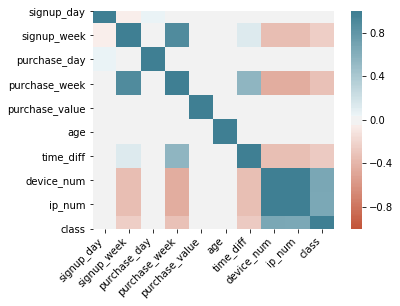

In [25]:
# Correlation plot
corr=data_rf.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

In [26]:
#just keep the top 50 country, everything else is "other"
#get countries from 51 to last one
bottom_countries = data_rf.groupby('country').size().sort_values(ascending=False)[50:].index
x = dict.fromkeys(bottom_countries, 'Other')
data_rf['country'] = data_rf['country'].replace(x)
  
#make dummy
data_rf = pandas.get_dummies(data_rf, drop_first=True) 

#split into train and test to avoid overfitting
train, test = train_test_split(data_rf, test_size = 0.34)

In [27]:
#build the model
rf = RandomForestClassifier(n_estimators=100, max_features=3, oob_score=True)
rf.fit(train.drop('class', axis=1), train['class'])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features=3, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=True, random_state=None,
                       verbose=0, warm_start=False)

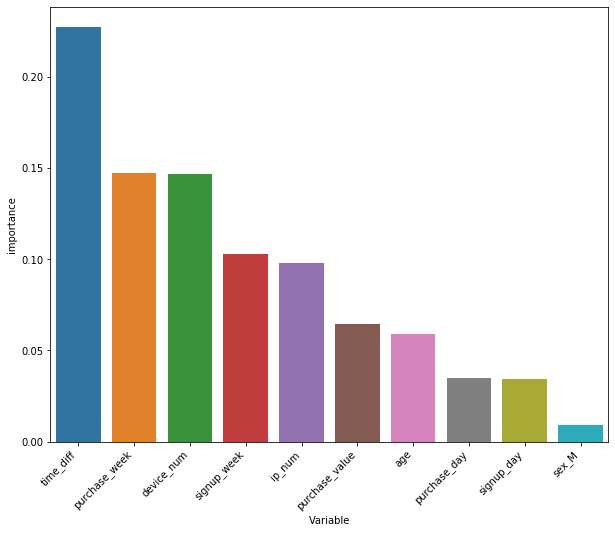

In [56]:
# Feature_importances, Top 10
feature_importances = pd.DataFrame(rf.feature_importances_,
                                   index = train.drop('class', axis=1).columns,
                                   columns=['importance']).sort_values('importance',ascending=False)
feature_importances.reset_index(inplace=True)
feature_importances.rename(columns={'index':'Variable'},inplace=True)

fig, ax = plt.subplots(figsize=(10, 8))
sns.barplot(x='Variable', y='importance', data=feature_importances[0:10])
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);
plt.show()

In [62]:
# Make predictions 
train_true = train['class']
test_true = test['class']
train_pred = rf.predict(train.drop('class', axis=1))
test_pred = rf.predict(test.drop('class', axis=1))

In [65]:
#let's print OOB accuracy and confusion matrix
print("OOB accuracy is", round(rf.oob_score_ *100,2), "%" 
"\nOOB Confusion Matrix", 
"\n",
pandas.DataFrame(confusion_matrix(train_pred, rf.oob_decision_function_[:,1].round(), labels=[0, 1]))
)

OOB accuracy is 95.67 %
OOB Confusion Matrix 
        0     1
0  90423    22
1   4292  4996


In [64]:
#and let's print test accuracy and confusion matrix
print(
"Test accuracy is", round(100*rf.score(test.drop('class', axis=1),test['class']),2),'%' 
"\nTest Set Confusion Matrix", 
"\n",
pandas.DataFrame(confusion_matrix(test_true, test_pred, labels=[0, 1]))
)

Test accuracy is 95.6 %
Test Set Confusion Matrix 
        0     1
0  46511     5
1   2254  2609


The confusion matrix looks good. 
We are not overfitting given that OOB and test results are very similar. 
Class 0 error is almost zero, and we are doing surprisignly well also with regards to class 1 error, which is pretty rare.

However, since the challenge asks about false positives and false negatives, this usually implies building the ROC and look for possible cut-off points. 
And in general, especially when dealing with fraud, you should always do the cut-off analysis. 
There is no reason why the default 0.5 value has to be the best one.

In [66]:
train_fpr, train_tpr, _ = roc_curve(train_true, train_pred)
test_fpr, test_tpr, _ = roc_curve(test_true, test_pred)
train_auc = np.round(auc(train_fpr, train_tpr), 3)
test_auc = np.round(auc(test_fpr, test_tpr), 3)

In [67]:
# Classification report
print(classification_report(y_true=test_true, y_pred=(test_pred > 0.5).astype(int)))

              precision    recall  f1-score   support

           0       0.95      1.00      0.98     46516
           1       1.00      0.54      0.70      4863

    accuracy                           0.96     51379
   macro avg       0.98      0.77      0.84     51379
weighted avg       0.96      0.96      0.95     51379



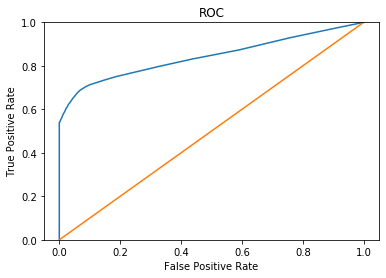

In [69]:
#Let's get false positive rate and true positive rate and plot them in the ROC
fpr, tpr, thresholds = roc_curve(test['class'],pred_prob)
#plot
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1])
plt.ylim([0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.show()

Based on the ROC, if we care about minimizing false positive, we would choose a cut-off that would give us true positive rate near 0.6 and false positive rate basically zero (this was similar to the default random forest output). 
However, if we care about maximizing true positive rate, we will have to significantly decrease the cut-off. This way we will classify more events as “1”: some will be true ones (so true positive goes up) and many, unfortunately, will be false ones (so false positive will also go up). 

We are very interested in the recall score, because that is the metric that will help us try to capture the most fraudulent transactions. If you think how Accuracy, Precision and Recall work for a confusion matrix, recall would be the most interesting:

Accuracy = (TP+TN)/total
Precision = TP/(TP+FP)
Recall = TP/(TP+FN)

As we know, due to the imbalacing of the data, many observations could be predicted as False Negatives, being, that we predict a normal transaction, but it is in fact a fraudulent one. Recall captures this.
- Obviously, trying to increase recall, tends to come with a decrease of precision. However, in our case, if we predict that a transaction is fraudulent and turns out not to be, is not a massive problem compared to the opposite. (needs to know false positive or false negative causes more trouble)
- We could even apply a cost function when having FN and FP with different weights for each type of error, but let's leave that aside for now.

In [ ]:
# Initialize H2O cluster
h2o.init()
h2o.remove_all()

In [ ]:
# Transform to H2O Frame, and make sure the target variable is categorical
h2o_df = H2OFrame(data)

for name in ['signup_day', 'purchase_day', 'source', 'browser', 'sex', 'country', 'class']:
    h2o_df[name] = h2o_df[name].asfactor()

h2o_df.summary()

In [ ]:
# Split into 70% training and 30% test dataset
strat_split = h2o_df['class'].stratified_split(test_frac=0.3, seed=42)

train = h2o_df[strat_split == 'train']
test = h2o_df[strat_split == 'test']

# Define features and target
feature = ['signup_day', 'signup_week', 'purchase_day', 'purchase_week', 'purchase_value', 
           'source', 'browser', 'sex', 'age', 'country', 'time_diff', 'device_num', 'ip_num']
target = 'class'

In [ ]:
# Build random forest model 
model = H2ORandomForestEstimator(balance_classes=True, ntrees=100, mtries=-1, stopping_rounds=5, 
                                 stopping_metric='auc', score_each_iteration=True, seed=42)
model.train(x=feature, y=target, training_frame=train, validation_frame=test)

In [ ]:
model.score_history()

In [ ]:
# Feature importance
importance = model.varimp(use_pandas=True)

fig, ax = plt.subplots(figsize=(10, 8))
sns.barplot(x='scaled_importance', y='variable', data=importance)
plt.show()

In [5]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...


CalledProcessError: Command '['/usr/bin/java', '-version']' returned non-zero exit status 1.